# Fashion MNIST dataset classification

In this notebook we classify clothing items from the Fashion MNIST dataset. Using this dataset, we will demonstrate how to develop a network architecture that includes ten neurons whose outputs represent the probability of the classes.

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import random
import time

%matplotlib inline

In [4]:
# Reproductibily

def set_seeds():
    SEED_VALUE = 1

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

## DataLoader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean, std
])

train_set = datasets.FashionMNIST(root = "MNIST", download = True, train = True, transform = transform)
validation_set = datasets.FashionMNIST(root = "MNIST", download = True, train = False, transform = transform) #validation set

print("Total Train Images: ", len(train_set))
print("Total validation Images: ", len(validation_set))

Total Train Images:  60000
Total validation Images:  10000


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 64)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle = False, batch_size = 64)

In [7]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  
}

## Data visualization

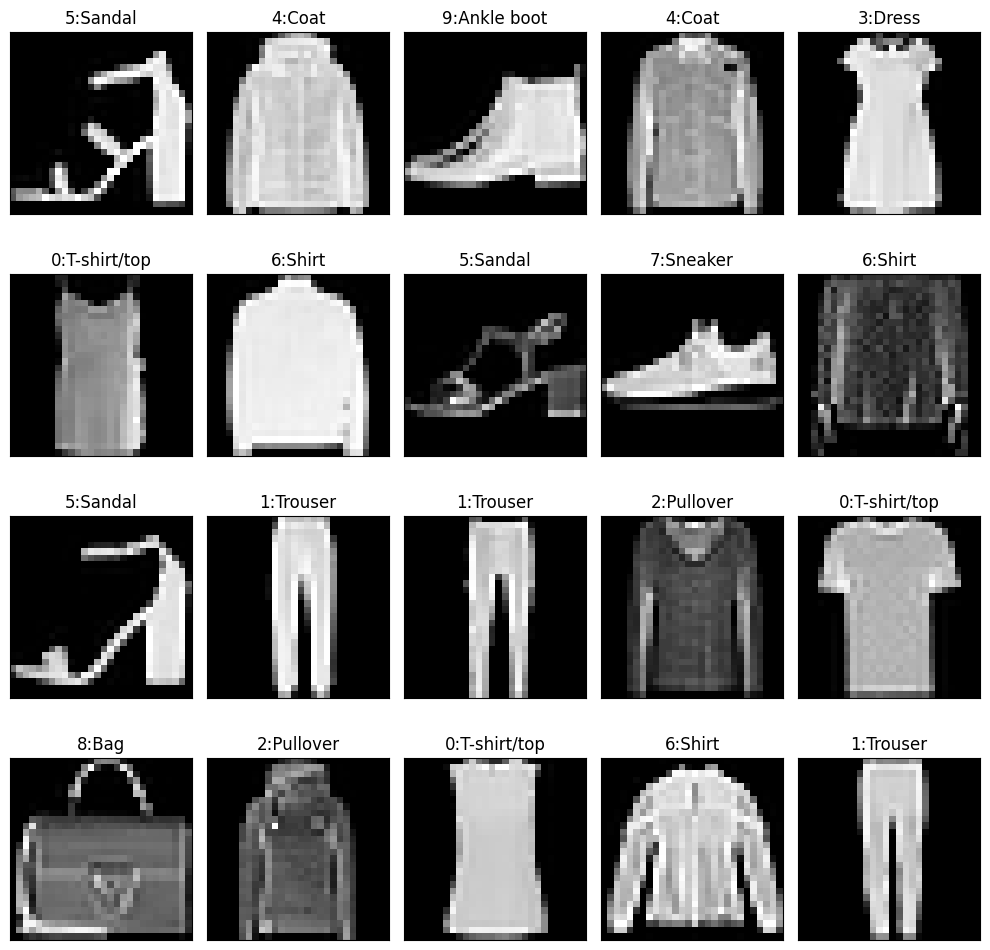

In [8]:
def view_images(train_loader, n=20):
    fig = plt.figure(figsize=(10, 10))

    images, labels = next(iter(train_loader)) # First batch iteration

    num_rows = 4
    num_cols = int(np.ceil(n / num_rows))

    for idx in range(min(n, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

view_images(train_loader)

## Model architecture


1. Input Data: The image input data is pre-processed (flattened) from a 2-Dimensional array [28x28] to 1-Dimensional vector of length [784x1] where the elements in this input vector are the normalized pixel intensities.

2. Hidden Layers: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc.).

3. Output Layer: We now have ten neurons in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example.

4. Dense Layers: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The weights associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

5. Softmax Function: The values from each of the neurons in the output layer are pased through a log_softmax() function to produce a probability score for each of the ten cloth items in the dataset.

6. Network Output: The network output (y'), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing (y') through the argmax function to determine the index of the predicted label.

7. Loss Function: The loss function used is Negative Log Likelihood Loss. It is computed from the ground truth labels (y') and the output log probabilities of the network (y'). Note that y and y' are both matrices whose shape is (Batch Size, Num Classes).

In [9]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Gradually reduce the size to extract only the most important info
        self.fc0 = nn.Linear(784, 512) # Summarizing/generalizing the data (prevent overlift) - 1st fully connected layer
        self.bn0 = nn.BatchNorm1d(512) # Batch normalization
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,num_classes) # 5th layer

        self.dropout = nn.Dropout(p=0.3) # Random drop of 30% of the neurons

    def forward(self, x):
        x = x.view(x.shape[0], -1) # Flattening the tensor: (B,784)  --> 28x28 = 784
        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        # Output layer with softmax activation
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)

        return x

# Instantiate the model.
mlp_model = MLP(num_classes = 10)

In [10]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

| Layer Name | Output Shape | Parameters | Explanation                                 |
| ---------- | ------------ | ---------- | ------------------------------------------- |
| `fc0`      | `[1, 512]`   | `401,920`  | 784 inputs × 512 outputs + 512 biases       |
| `bn0`      | `[1, 512]`   | `1,024`    | BatchNorm has 512 γ (scale) + 512 β (shift) |
| `fc1`      | `[1, 256]`   | `131,328`  | 512 × 256 + 256                             |
| `fc2`      | `[1, 128]`   | `32,896`   | 256 × 128 + 128                             |
| `fc3`      | `[1, 64]`    | `8,256`    | 128 × 64 + 64                               |
| `fc4`      | `[1, 10]`    | `650`      | 64 × 10 + 10                                |

| Item                        | Value       | What it means                                            |
| --------------------------- | ----------- | -------------------------------------------------------- |
| `Total params`              | **576,970** | All learnable weights in the model                       |
| `Trainable params`          | 576,970     | All parameters can be updated via gradient descent       |
| `Non-trainable params`      | 0           | No frozen layers                                         |
| `Estimated Total Size (MB)` | 2.33 MB     | Size in memory to store weights and intermediate outputs |

## Training the model

In [11]:
criterion = F.nll_loss # Negative Log Likelihood Loss
# Alternative : nn.CrosEntropyLoss() : combines log_softmax + nll_loss in one go
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2) # Learning rate: 0.01 (fast but risky)
num_epochs = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
def train(model, trainloader, criterion, optimizer,DEVICE):
    model.train() # Enable dropout, batchnorm in training mode
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in trainloader: # Loop over batches
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()              # Clear old gradients
        outputs = model(images)            # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights


        running_loss += loss.item()  # Add scalar loss
        _, predicted = torch.max(outputs.data, dim=1)  # Pick predicted class
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [13]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval() # Disable dropout, batchnorm behaves differently
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Saves memory and speeds up computation
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [14]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/20 - Train Loss: 0.5633, Train Accuracy: 79.81% - Val Loss: 0.4289, Val Accuracy: 83.98%
Epoch 02/20 - Train Loss: 0.4407, Train Accuracy: 84.27% - Val Loss: 0.3794, Val Accuracy: 86.11%
Epoch 03/20 - Train Loss: 0.3990, Train Accuracy: 85.64% - Val Loss: 0.3871, Val Accuracy: 85.94%
Epoch 04/20 - Train Loss: 0.3709, Train Accuracy: 86.61% - Val Loss: 0.3618, Val Accuracy: 87.17%
Epoch 05/20 - Train Loss: 0.3517, Train Accuracy: 87.33% - Val Loss: 0.3517, Val Accuracy: 87.47%
Epoch 06/20 - Train Loss: 0.3380, Train Accuracy: 87.74% - Val Loss: 0.3341, Val Accuracy: 87.77%
Epoch 07/20 - Train Loss: 0.3255, Train Accuracy: 88.26% - Val Loss: 0.3438, Val Accuracy: 87.81%
Epoch 08/20 - Train Loss: 0.3103, Train Accuracy: 88.70% - Val Loss: 0.3246, Val Accuracy: 88.14%
Epoch 09/20 - Train Loss: 0.3025, Train Accuracy: 88.97% - Val Loss: 0.3300, Val Accuracy: 88.43%
Epoch 10/20 - Train Loss: 0.2912, Train Accuracy: 89.29% - Val Loss: 0.3149, Val Accuracy: 88.39%
Epoch 11/20 - Train 

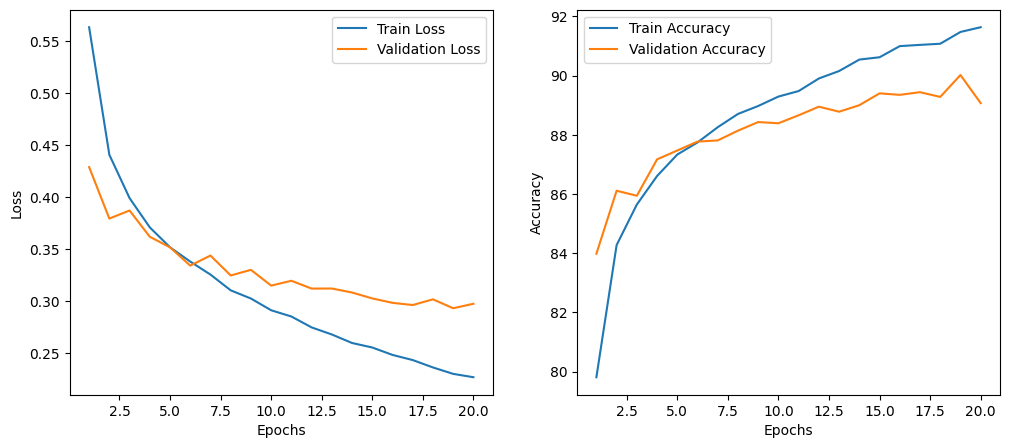

In [15]:
main(mlp_model, train_loader, validation_loader, epochs = num_epochs, DEVICE = DEVICE)

## Results (infering image class)

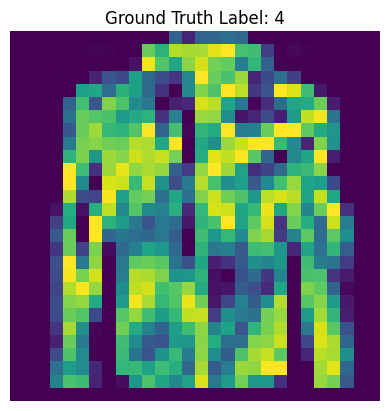

In [16]:
images, gt_labels = next(iter(validation_loader)) # Convert the Pytorch dataloader to an interator and fetch one batch

rand_idx = random.choice(range(len(images))) 

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [17]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))  # Logits or log-probabilities for each class

prob_score_batch = batch_outputs.softmax(dim=1).cpu() # Converts the raw scores (logits) into probabilities

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.001
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.949
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.038
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.012
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.000


## Confusion Matrix

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). It is basically telling us how many times he got the result right and how many times it was wrong.

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) 

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

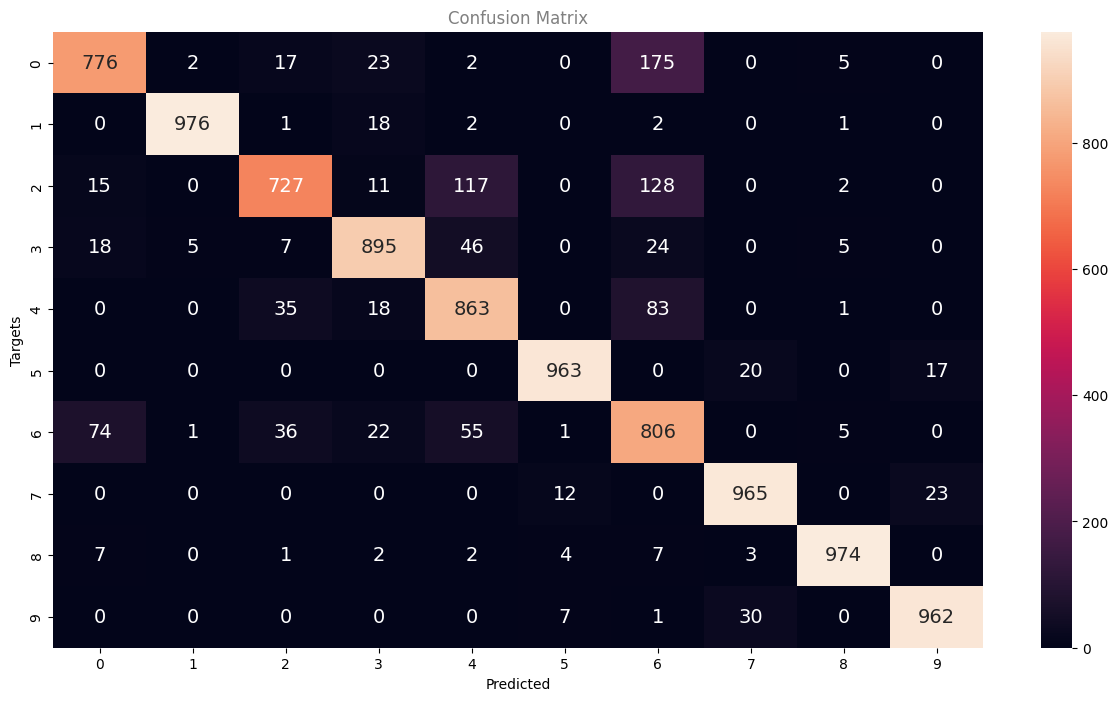

In [20]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in validation_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

# Plot the confusion matrix as a heatmap.
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()